Install requirements

In [ ]:
!pip install tensorflow tensorflow-datasets librosa

Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import librosa
import numpy as np

Only grab the dataset where instument == keyboard

In [ ]:
# Constants
KEYBOARD_FAMILY_LABEL = 4 # According to NSynth dataset family label
SAMPLE_RATE = 16000
TRIM_LENGTH = 3 * SAMPLE_RATE  # Trim to the first 3 seconds

def process_data(example):
    audio = example['audio']
    instrument_family = example['instrument']['family']
    pitch = example['pitch']

    is_keyboard = tf.equal(instrument_family, KEYBOARD_FAMILY_LABEL)

    def process_keyboard_sample(audio, pitch):
        audio = audio[:TRIM_LENGTH]
        if pitch < 21:
            # Instead of returning None, return a marker (e.g., a zero-length tensor)
            return tf.zeros((0,)), tf.constant(-1, dtype=tf.int64)
        else:
            pitch = pitch - 21
            return audio, pitch

    return tf.cond(is_keyboard, lambda: process_keyboard_sample(audio, pitch), lambda: (audio, pitch))

def filter_keyboard_samples(example):
    return tf.equal(example['instrument']['family'], KEYBOARD_FAMILY_LABEL)

def filter_invalid_samples(audio, pitch):
    # Check if the sample is valid (not marked for removal)
    return tf.size(audio) > 0 and tf.not_equal(pitch, -1)

def get_data_loader(data_split, batch_size=64, num_batches=None):
    ds = tfds.load('nsynth', split=data_split, as_supervised=False)

    ds = ds.filter(filter_keyboard_samples)
    ds = ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.filter(filter_invalid_samples)
    ds = ds.batch(batch_size)
    if num_batches:
        ds = ds.take(num_batches)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

In [ ]:
# Input to model
batch_size = 32
train_loader = get_data_loader('train', batch_size, num_batches=80)
val_loader = get_data_loader('valid', batch_size, num_batches=10)
test_loader = get_data_loader('test', batch_size, num_batches=10)
classes = list(range(88))

Dl Completed...:   0%|          | 0/1069 [00:00<?, ? file/s]

Dataset nsynth downloaded and prepared to /root/tensorflow_datasets/nsynth/full/2.3.3. Subsequent calls will reuse this data.


In [ ]:
for audio, pitch in train_loader.take(1):
    print(pitch)
    print(f"Pitch: {pitch}")

tf.Tensor(
[85 10 60 33 48 84 21 54 13 33  0  6 49 52 56 17  4 74  6 40 63 20 44 41
  7 22 67 64  8 78 16 48], shape=(32,), dtype=int64)
Pitch: [85 10 60 33 48 84 21 54 13 33  0  6 49 52 56 17  4 74  6 40 63 20 44 41
  7 22 67 64  8 78 16 48]


In [ ]:
# printing a sample audio and pitch value
for audio, pitch in train_loader.take(1):
    first_sample_audio = audio[0]
    first_sample_pitch = pitch[0]

    # Calculate the maximum and minimum values
    max_value = tf.reduce_max(first_sample_audio)
    min_value = tf.reduce_min(first_sample_audio)

    # Calculate the range (max - min)
    range_value = max_value - min_value

    print(f"First sample audio max value: {max_value.numpy()}")
    print(f"First sample audio min value: {min_value.numpy()}")
    print(f"First sample audio range: {range_value.numpy()}")
    print(f"First sample pitch: {first_sample_pitch.numpy()}")

First sample audio max value: 0.46275418996810913
First sample audio min value: -0.46886491775512695
First sample audio range: 0.9316191077232361
First sample pitch: 85


In [ ]:
for audio, pitch in train_loader:
  print(audio.shape)
  print(pitch.shape)


(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000)
(32,)
(32, 48000

In [ ]:
# get number of batches in each loader
def get_dataset_length(data_loader):
    length = 0
    for _ in data_loader:
        length += 1
    return length

# Use this function to get the length of your data loaders
test_loader_length = get_dataset_length(test_loader)
val_loader_length = get_dataset_length(val_loader)
train_loader_length = get_dataset_length(train_loader)

print(f"Train loader length: {train_loader_length}")
print(f"Validation loader length: {val_loader_length}")
print(f"Test loader length: {test_loader_length}")

Train loader length: 80
Validation loader length: 10
Test loader length: 10


In [ ]:
# get number of samples in each loader
def get_dataset_sample_count(data_loader):
    total_samples = 0
    for audio, pitch in data_loader:
        # Count the number of samples in each batch
        batch_samples = tf.shape(audio)[0]  # assuming audio is a 2D tensor [batch_size, features]
        total_samples += batch_samples
    return total_samples

# Use this function to get the number of samples in your data loaders
test_samples_count = get_dataset_sample_count(test_loader)
val_samples_count = get_dataset_sample_count(val_loader)
train_samples_count = get_dataset_sample_count(train_loader)

print(f"Train loader samples: {train_samples_count}")
print(f"Validation loader samples: {val_samples_count}")
print(f"Test loader samples: {test_samples_count}")

Train loader samples: 2560
Validation loader samples: 320
Test loader samples: 320


In [ ]:
################################################################################################################################################################
####################################################################### Model and Training #####################################################################
################################################################################################################################################################

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

torch.manual_seed(10)

In [ ]:
for audio, pitch in train_loader.take(1):
  print(f"Audio shape: {audio.shape}")

Audio shape: (32, 48000)


In [ ]:
# Model architecture

'''
class PitchDetectionModel(nn.Module):
  def __init__(self):
    super(PitchDetectionModel, self).__init__()
    self.conv1 = nn.Conv1d(in_channels=1,     out_channels=1024,  kernel_size=4, stride=4)
    self.conv2 = nn.Conv1d(in_channels=1024,  out_channels=128,   kernel_size=4, stride=4)
    self.conv3 = nn.Conv1d(in_channels=128,   out_channels=128,   kernel_size=4, stride=4)
    self.conv4 = nn.Conv1d(in_channels=128,   out_channels=256,   kernel_size=2, stride=2)
    self.pool  = nn.MaxPool1d(2, 2)
    self.fc1   = nn.Linear(256*23, 88)

  def forward(self, x):                   # Input length 48,000,  channels 1
    x = self.pool(F.relu(self.conv1(x)))  #       length 6,000,   channels 1024
    x = self.pool(F.relu(self.conv2(x)))  #       length 750,     channels 128
    x = self.pool(F.relu(self.conv3(x)))  #       length 93,      channels 128
    x = self.pool(F.relu(self.conv4(x)))  #       length 23,      channels 256
    x = x.view(-1, 256*23)                # Flatten the tensor
    x = self.fc1(x)                       # Output length 88
    # x = F.softmax(self.fc1(x))
    return x                              # Assuming CELoss
'''

'\nclass PitchDetectionModel(nn.Module):\n  def __init__(self):\n    super(PitchDetectionModel, self).__init__()\n    self.conv1 = nn.Conv1d(in_channels=1,     out_channels=1024,  kernel_size=4, stride=4)\n    self.conv2 = nn.Conv1d(in_channels=1024,  out_channels=128,   kernel_size=4, stride=4)\n    self.conv3 = nn.Conv1d(in_channels=128,   out_channels=128,   kernel_size=4, stride=4)\n    self.conv4 = nn.Conv1d(in_channels=128,   out_channels=256,   kernel_size=2, stride=2)\n    self.pool  = nn.MaxPool1d(2, 2)\n    self.fc1   = nn.Linear(256*23, 88)\n\n  def forward(self, x):                   # Input length 48,000,  channels 1\n    x = self.pool(F.relu(self.conv1(x)))  #       length 6,000,   channels 1024\n    x = self.pool(F.relu(self.conv2(x)))  #       length 750,     channels 128\n    x = self.pool(F.relu(self.conv3(x)))  #       length 93,      channels 128\n    x = self.pool(F.relu(self.conv4(x)))  #       length 23,      channels 256\n    x = x.view(-1, 256*23)              

In [ ]:
from keras import layers, models

In [ ]:
'''
class PitchDetectionModel(tf.keras.Model):
  def __init__(self):
    super(PitchDetectionModel, self).__init__()
    self.conv1 = tf.keras.layers.Conv1D(in_channels=1,     out_channels=1024,  kernel_size=4, stride=4)
    self.conv2 = tf.keras.layers.Conv1D(in_channels=1024,  out_channels=128,   kernel_size=4, stride=4)
    self.conv3 = tf.keras.layers.Conv1D(in_channels=128,   out_channels=128,   kernel_size=4, stride=4)
    self.conv4 = tf.keras.layers.Conv1D(in_channels=128,   out_channels=256,   kernel_size=2, stride=2)
    self.pool  = tf.keras.layers.MaxPool1D(2, 2)
    self.fc1   = tf.keras.layers.Dense(88)

  def call(self, x):                   # Input length 48,000,  channels 1
    x = self.pool(tf.nn.relu(self.conv1(x)))  #       length 6,000,   channels 1024
    x = self.pool(tf.nn.relu(self.conv2(x)))  #       length 750,     channels 128
    x = self.pool(tf.nn.relu(self.conv3(x)))  #       length 93,      channels 128
    x = self.pool(tf.nn.relu(self.conv4(x)))  #       length 23,      channels 256
    x = tf.reshape(x, (-1, 256*23))                # Flatten the tensor
    x = self.fc1(x)                       # Output length 88
    # x = tf.nn.softmax(self.fc1(x))
    return x                              # Assuming CELoss

model = PitchDetectionModel()
'''

'\nclass PitchDetectionModel(tf.keras.Model):\n  def __init__(self):\n    super(PitchDetectionModel, self).__init__()\n    self.conv1 = tf.keras.layers.Conv1D(in_channels=1,     out_channels=1024,  kernel_size=4, stride=4)\n    self.conv2 = tf.keras.layers.Conv1D(in_channels=1024,  out_channels=128,   kernel_size=4, stride=4)\n    self.conv3 = tf.keras.layers.Conv1D(in_channels=128,   out_channels=128,   kernel_size=4, stride=4)\n    self.conv4 = tf.keras.layers.Conv1D(in_channels=128,   out_channels=256,   kernel_size=2, stride=2)\n    self.pool  = tf.keras.layers.MaxPool1D(2, 2)\n    self.fc1   = tf.keras.layers.Dense(88)\n\n  def call(self, x):                   # Input length 48,000,  channels 1\n    x = self.pool(tf.nn.relu(self.conv1(x)))  #       length 6,000,   channels 1024\n    x = self.pool(tf.nn.relu(self.conv2(x)))  #       length 750,     channels 128\n    x = self.pool(tf.nn.relu(self.conv3(x)))  #       length 93,      channels 128\n    x = self.pool(tf.nn.relu(self.con

In [ ]:

# class PitchDetectionModel(tf.keras.Model):
#     def __init__(self):
#         super(PitchDetectionModel, self).__init__()
#         self.reshape = layers.Reshape((48000, 1))
#         self.conv1 = layers.Conv1D(1024, kernel_size=4, strides=4, activation='relu')
#         self.conv2 = layers.Conv1D(128, kernel_size=4, strides=4, activation='relu')
#         self.conv3 = layers.Conv1D(128, kernel_size=4, strides=4, activation='relu')
#         self.conv4 = layers.Conv1D(256, kernel_size=2, strides=2, activation='relu')
#         self.pool = layers.MaxPooling1D(2)
#         self.flatten = layers.Flatten()
#         self.fc1 = layers.Dense(88)

#     def call(self, x):
#         x = self.reshape(x)
#         x = self.pool(self.conv1(x))
#         x = self.pool(self.conv2(x))
#         x = self.pool(self.conv3(x))
#         x = self.pool(self.conv4(x))
#         x = self.flatten(x)
#         return self.fc1(x)


In [ ]:
class PitchDetectionModel(tf.keras.Model):
    def __init__(self):
        super(PitchDetectionModel, self).__init__()
        self.reshape = layers.Reshape((48000, 1))
        self.conv1 = layers.Conv1D(1024, kernel_size=4, strides=4, activation='relu')
        self.drop1 = layers.Dropout(0.2)  # Dropout layer after conv1
        self.conv2 = layers.Conv1D(128, kernel_size=4, strides=4, activation='relu')
        self.drop2 = layers.Dropout(0.2)  # Dropout layer after conv4
        self.conv3 = layers.Conv1D(128, kernel_size=4, strides=4, activation='relu')
        self.drop3 = layers.Dropout(0.5)  # Dropout layer after conv4
        self.conv4 = layers.Conv1D(256, kernel_size=2, strides=2, activation='relu')
        self.drop4 = layers.Dropout(0.5)  # Dropout layer after conv4
        self.pool = layers.MaxPooling1D(2)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(88)

    def call(self, x, training=False):
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.drop1(x, training=training)  # Apply dropout only during training
        x = self.conv2(x)
        x = self.pool(x)
        x = self.drop2(x, training=training)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.drop3(x, training=training)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.drop4(x, training=training)
        x = self.flatten(x)
        return self.fc1(x)


In [ ]:
'''
class PitchDetectionModel(tf.keras.Model):
  def __init__(self):
    super(PitchDetectionModel, self).__init__()
    self.reshape = layers.Reshape((48000, 1))
    self.conv1 = layers.Conv1D(1024, kernel_size=4, strides=4, activation='relu')
    self.conv2 = layers.Conv1D(128, kernel_size=4, strides=4, activation='relu')
    self.conv3 = layers.Conv1D(128, kernel_size=4, strides=4, activation='relu')
    self.conv4 = layers.Conv1D(256, kernel_size=2, strides=2, activation='relu')
    self.pool = layers.MaxPooling1D(2)
    self.flatten = layers.Flatten()
    self.fc1 = layers.Dense(88)

  def call(self, x):                   # Input length 48,000,  channels 1
    x = self.pool(tf.nn.relu(self.conv1(x)))  #       length 6,000,   channels 1024
    x = self.pool(tf.nn.relu(self.conv2(x)))  #       length 750,     channels 128
    x = self.pool(tf.nn.relu(self.conv3(x)))  #       length 93,      channels 128
    x = self.pool(tf.nn.relu(self.conv4(x)))  #       length 23,      channels 256
    x = tf.reshape(x, (-1, 256*23))                # Flatten the tensor
    x = self.fc1(x)                       # Output length 88
    # x = tf.nn.softmax(self.fc1(x))
    return x                              # Assuming CELoss
'''

"\nclass PitchDetectionModel(tf.keras.Model):\n  def __init__(self):\n    super(PitchDetectionModel, self).__init__()\n    self.reshape = layers.Reshape((48000, 1))\n    self.conv1 = layers.Conv1D(1024, kernel_size=4, strides=4, activation='relu')\n    self.conv2 = layers.Conv1D(128, kernel_size=4, strides=4, activation='relu')\n    self.conv3 = layers.Conv1D(128, kernel_size=4, strides=4, activation='relu')\n    self.conv4 = layers.Conv1D(256, kernel_size=2, strides=2, activation='relu')\n    self.pool = layers.MaxPooling1D(2)\n    self.flatten = layers.Flatten()\n    self.fc1 = layers.Dense(88)\n\n  def call(self, x):                   # Input length 48,000,  channels 1\n    x = self.pool(tf.nn.relu(self.conv1(x)))  #       length 6,000,   channels 1024\n    x = self.pool(tf.nn.relu(self.conv2(x)))  #       length 750,     channels 128\n    x = self.pool(tf.nn.relu(self.conv3(x)))  #       length 93,      channels 128\n    x = self.pool(tf.nn.relu(self.conv4(x)))  #       length 23, 

In [ ]:
# Create an instance of the model
model = PitchDetectionModel()

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(0.001),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train the model
# history = model.fit(train_loader, epochs=10, validation_data=val_loader)

print("Fit model on training data")
history = model.fit(
  x=train_loader,
  epochs=35,
  verbose=1,
  validation_data=val_loader
)
'''
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)
'''

import matplotlib.pyplot as plt

training_accuracy = history.history['sparse_categorical_accuracy']
validation_accuracy = history.history['val_sparse_categorical_accuracy']

epochs = range(1, len(training_accuracy) + 1)

# Plotting the accuracy graph
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_loader)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

10/10 [==============================] - 1s 114ms/step - loss: 2.4121 - sparse_categorical_accuracy: 0.6750
Test accuracy: 0.675000011920929, Test loss: 2.412091016769409


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display

In [ ]:
sample = librosa.load("/content/Live 52 notes 4 seconds on 1 second off.m4a", sr=16000)

<ipython-input-22-359964fccd26>:1: UserWarning: PySoundFile failed. Trying audioread instead.
  sample = librosa.load("/content/Live 52 notes 4 seconds on 1 second off.m4a", sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


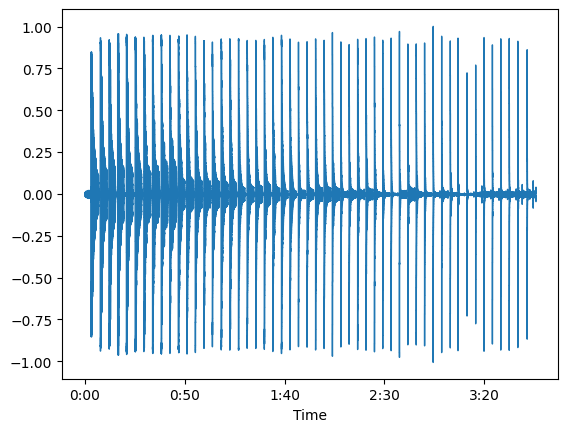

In [ ]:
sample_rate = 16000
librosa.display.waveshow(sample[0], sr=sample_rate)
Audio(sample[0], rate=sample_rate)

In [ ]:
splitAudio = librosa.effects.split(sample[0], top_db=20)
splitAudio.shape

(52, 2)

In [ ]:
newAudios = np.empty((1,48000),dtype=np.float32)
for begin, end in splitAudio:
  subAudio = sample[0][begin:end]
  subAudio = np.array(subAudio[:48000])
  subAudio = np.pad(subAudio, (0, 48000-len(subAudio)))
  #
  rms = np.sqrt(np.mean(np.square(subAudio)))
  print(f"rms values are:",{rms})
  normalized_array = subAudio * rms
  #normalized_array = librosa.util.normalize(subAudio, norm=1, axis=0)
  print(f"max and min of the normalize array is:",{max(normalized_array),min(normalized_array)})

  newAudios = np.append(newAudios, [normalized_array], axis=0)
  # librosa.display.waveshow(subAudio, sr=sample_rate)
  # display(Audio(subAudio, rate=sample_rate))

newAudios = newAudios[1:]
newAudios.shape

In [88]:
midi_labels_list = list(range(21,109))
black_notes = [22,25,27,30,32,34,37,39,42,44,46,49,51,54,56,58,61,63,66,68,70,73,75,78,80,82,85,87,90,92,94,97,99,102,104,106]

def filter_blacks(number):
  if number in black_notes:
    return False

  return True

midi_labels_list = list(filter(filter_blacks, midi_labels_list))
midi_labels = np.array(midi_labels_list,dtype=np.int64)
len(midi_labels)

52

In [90]:
new_data_loader = zip(newAudios, midi_labels)

new_data_dict = dict()
for audio, pitch in new_data_loader:
  new_data_dict[pitch] = audio

#print(new_data_dict)

In [91]:
pitch_tensor = tf.convert_to_tensor(midi_labels, dtype=tf.int64)
audio_tensor = tf.convert_to_tensor(newAudios, dtype=tf.float32)
new_dataset = tf.data.Dataset.from_tensor_slices((audio_tensor, pitch_tensor))
new_dataset = new_dataset.batch(1)

In [ ]:
debug_test_loader = get_data_loader('test', batch_size=1, num_batches=52)
db_pitch_mean = dict()
for audio, pitch in debug_test_loader.take(52):
    print(f"Pitch: {pitch}")
    print(f"Pitch type: {pitch.dtype}")
    print(f"Pitch shape: {pitch.shape}")
    print(f"audio: {audio}")
    print(f"average audio magnitude: {tf.math.reduce_mean(audio)}")
    print(f"audio type: {audio.dtype}")
    print(f"audio shape: {audio.shape}")

In [ ]:
for audio, pitch in new_dataset.take(8):
    print(f"Pitch: {pitch}")
    print(f"Pitch type: {pitch.dtype}")
    print(f"Pitch shape: {pitch.shape}")
    print(f"audio: {audio}")
    print(f"average audio magnitude: {tf.math.reduce_mean(audio)}")
    print(f"audio type: {audio.dtype}")
    print(f"audio shape: {audio.shape}")

In [94]:
new_ds_max_value = tf.constant(float('-inf'), dtype=tf.float32)
for audio_batch, _ in new_dataset:
  batch_max = tf.math.reduce_max(audio_batch)
  new_ds_max_value = tf.maximum(new_ds_max_value, batch_max)
print("Maximum value in audio_tensor across the new_dataset:", new_ds_max_value.numpy())
test_ds_max_value = tf.constant(float('-inf'), dtype=tf.float32)
for audio_batch, _ in debug_test_loader:
  batch_max = tf.math.reduce_max(audio_batch)
  test_ds_max_value = tf.maximum(test_ds_max_value, batch_max)
print("Maximum value in audio_tensor across the debug_test_loader:", test_ds_max_value.numpy())

Maximum value in audio_tensor across the new_dataset: 0.16842514
Maximum value in audio_tensor across the debug_test_loader: 1.0


In [93]:
new_ds_min_value = tf.constant(float('inf'), dtype=tf.float32)
for audio_batch, _ in new_dataset:
  batch_min = tf.math.reduce_min(audio_batch)
  new_ds_min_value = tf.minimum(new_ds_min_value, batch_min)
print("Minimum value in audio_tensor across the new_dataset:",new_ds_min_value.numpy())
test_ds_min_value = tf.constant(float('inf'), dtype=tf.float32)
for audio_batch, _ in debug_test_loader:
  batch_min = tf.math.reduce_min(audio_batch)
  #print(f"current_minimum:,{batch_min.numpy()}")
  test_ds_min_value = tf.minimum(test_ds_min_value, batch_min)
print("Minimum value in audio_tensor across the debug_test_loader:", test_ds_min_value.numpy())

Minimum value in audio_tensor across the new_dataset: -0.1579164
Minimum value in audio_tensor across the debug_test_loader: -1.0


In [ ]:
db_test_pitch_mean = dict()
for audio, pitch in debug_test_loader.take(52):
    db_test_pitch_mean[pitch.numpy()[0]] = tf.math.reduce_mean(audio).numpy()
new_test_pitch_mean = dict()
for audio, pitch in new_dataset.take(52):
    new_test_pitch_mean[pitch.numpy()[0]] = tf.math.reduce_mean(audio).numpy()
pitch_mean_ratio = {k: new_test_pitch_mean[k]/db_test_pitch_mean[k] for k in new_test_pitch_mean.keys() & db_test_pitch_mean.keys()}

# storing the pitch and associated RMS of the original test dataset
db_test_pitch_RMS = dict()
for audio, pitch in debug_test_loader.take(52):
    db_test_pitch_RMS[pitch.numpy()[0]] = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(audio))).numpy()

# storing the pitch and associated RMS for the new dataset
new_test_pitch_RMS = dict()
for audio, pitch in new_dataset.take(52):
    new_test_pitch_RMS[pitch.numpy()[0]] = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(audio))).numpy()

# taking the RMS ratio between
pitch_RMS_ratio = {k: db_test_pitch_RMS[k]/new_test_pitch_RMS[k] for k in new_test_pitch_RMS.keys() & db_test_pitch_RMS.keys()}


print(pitch_RMS_ratio)
print(pitch_mean_ratio)
shared_pitches = list(pitch_mean_ratio.keys())
print(shared_pitches)

In [ ]:
new_RMS_normalized_audio = np.empty((1,48000),dtype=np.float32)
for pitch in shared_pitches:
  new_RMS_normalized_audio = np.append(
                                  new_RMS_normalized_audio,
                                  [new_data_dict[pitch]*pitch_RMS_ratio[pitch]],
                                  axis=0)

new_RMS_normalized_audio = new_RMS_normalized_audio[1:]
print(len(shared_pitches))
print(new_RMS_normalized_audio.shape)
shared_pitches_labels = np.array(shared_pitches,dtype=np.int64)

shared_pitches_tensor = tf.convert_to_tensor(shared_pitches_labels, dtype=tf.int64)
RMS_audio_tensor = tf.convert_to_tensor(new_RMS_normalized_audio, dtype=tf.float32)

new_RMS_dataset = tf.data.Dataset.from_tensor_slices((RMS_audio_tensor, shared_pitches_tensor))
new_RMS_dataset = new_RMS_dataset.batch(1)

In [99]:
# Evaluate debug_test_loader
test_loss, test_acc = model.evaluate(debug_test_loader,batch_size=1)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

52/52 [==============================] - 0s 7ms/step - loss: 2.1382 - sparse_categorical_accuracy: 0.7308
Test accuracy: 0.7307692170143127, Test loss: 2.138199806213379


In [95]:
# Evaluate on our own recorded data
test_loss, test_acc = model.evaluate(new_dataset,batch_size=1)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

52/52 [==============================] - 0s 7ms/step - loss: nan - sparse_categorical_accuracy: 0.0192
Test accuracy: 0.01923076994717121, Test loss: nan


In [43]:
# Evaluate on new_RMS_dataset
test_loss, test_acc = model.evaluate(new_RMS_dataset,batch_size=1)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

18/18 [==============================] - 0s 7ms/step - loss: 41.6082 - sparse_categorical_accuracy: 0.0000e+00
Test accuracy: 0.0, Test loss: 41.608184814453125


In [61]:
test_loss, test_acc = model.evaluate(x=audio_tensor, y=pitch_tensor,batch_size=1)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

52/52 [==============================] - 0s 7ms/step - loss: nan - sparse_categorical_accuracy: 0.0192
Test accuracy: 0.01923076994717121, Test loss: nan


In [112]:
# Constants
ORGAN_FAMILY_LABEL = 6 # According to NSynth dataset family label
ELECTRONIC_SOURCE_LABEL = 1
SAMPLE_RATE = 16000
TRIM_LENGTH = 3 * SAMPLE_RATE  # Trim to the first 3 seconds

def nprocess_data(example):
    audio = example['audio']
    instrument_family = example['instrument']['family']
    instrument_source = example['instrument']['source']
    pitch = example['pitch']

    is_organ = tf.equal(instrument_family, ORGAN_FAMILY_LABEL)
    is_electronic = tf.equal(instrument_source, ELECTRONIC_SOURCE_LABEL)

    def nprocess_organ_sample(audio, pitch):
        audio = audio[:TRIM_LENGTH]
        if pitch < 21:
            # Instead of returning None, return a marker (e.g., a zero-length tensor)
            return tf.zeros((0,)), tf.constant(-1, dtype=tf.int64)
        else:
            pitch = pitch - 21
            return audio, pitch

    return tf.cond((is_organ and is_electronic), lambda: nprocess_organ_sample(audio, pitch), lambda: (audio, pitch))

def nfilter_organ_samples(example):
    return tf.equal(example['instrument']['family'], ORGAN_FAMILY_LABEL)

def nfilter_electronic_samples(example):
    return tf.equal(example['instrument']['source'], ELECTRONIC_SOURCE_LABEL)

def nfilter_invalid_samples(audio, pitch):
    # Check if the sample is valid (not marked for removal)
    return tf.size(audio) > 0 and tf.not_equal(pitch, -1)

def nget_data_loader(data_split, batch_size=64, num_batches=None):
    ds = tfds.load('nsynth', split=data_split, as_supervised=False)

    ds = ds.filter(nfilter_organ_samples)
    ds = ds.filter(nfilter_electronic_samples)
    ds = ds.map(nprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.filter(nfilter_invalid_samples)
    ds = ds.batch(batch_size)
    if num_batches:
        ds = ds.take(num_batches)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

In [113]:
# Input to model
batch_size = 32
organ_test_loader = nget_data_loader('test', batch_size, num_batches=10)

In [115]:
# Evaluate organ_test_loader
test_loss, test_acc = model.evaluate(organ_test_loader)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

10/10 [==============================] - 1s 115ms/step - loss: 8.3869 - sparse_categorical_accuracy: 0.5938
Test accuracy: 0.59375, Test loss: 8.386850357055664
